In [41]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [42]:
# Hyperparameters
grid_size = 200  # Start with a smaller grid size
total_iterations = 1000

In [43]:
# Reaction-Diffusion parameters
pa = 0.6  # Coefficient for the activator's reaction rate.
pb = 0.8  # Coefficient controlling the interaction between activator and suppressor.
pe = 4.5  # Coefficient for the suppressor's reaction term (controls how the suppressor inhibits the activator).
d = 50  # Diffusion rate for the suppressor (higher value means faster diffusion of the suppressor).
dt = 1e-1  # Time step size for the simulation (controls how fast the system evolves with each iteration).
threshold = 1 # Threshold for determining whether the activator concentration affects the suppressor.
gamma = 625  # Reaction rate scaling factor (affects the speed of the reaction between the activator, suppressor, and mycelium).
ph = 1  # Coefficient related to the growth of the mycelium (scaling factor for the mycelium growth dynamics).
amax = 40  # Maximum allowed concentration for the activator (prevents uncontrolled growth of the activator).
smax = 80  # Maximum allowed concentration for the suppressor (prevents uncontrolled growth of the suppressor).
width = 1.0  # Controls the width of the dendrites formed during the growth process (affects the spatial spread of the reaction).


In [44]:
# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2
# n = torch.ones((grid_size, grid_size), device=device)
# n[:, mid:] = 0.3

# Nutrient landscape with nutrient islands
n = torch.ones((grid_size, grid_size), device=device) * 0.03  # Low baseline nutrient level
n[:, mid:] = 0.08
num_islands = 100  # Number of nutrient islands
island_radius = 3  # Radius of nutrient islands
high_nutrient_value = 0.9# Nutrient level inside islands

# Randomly place nutrient islands
#torch.manual_seed(torch.initial_seed())  # Ensure different islands each run

# Rocks (obstacles) on substrate that spawn randomly
num_rocks = 100
rock_radius = 3  # Radius of each rock
#torch.manual_seed(torch.initial_seed())  # Ensure different rocks each run

In [45]:
for _ in range(num_islands):
    # Random center for each island
    center_x = torch.randint(island_radius, grid_size - island_radius, (1,)).item()
    center_y = torch.randint(island_radius, grid_size - island_radius, (1,)).item()

    for i in range(grid_size):
        for j in range(grid_size):
            if (i - center_x)**2 + (j - center_y)**2 <= island_radius**2:
                n[i, j] = high_nutrient_value  # Set higher nutrient value inside the island


for _ in range(num_rocks):
    # Random center for each rock
    rock_x = torch.randint(rock_radius, grid_size - rock_radius, (1,)).item()
    rock_y = torch.randint(rock_radius, grid_size - rock_radius, (1,)).item()

    for i in range(grid_size):
        for j in range(grid_size):
            if (i - rock_x)**2 + (j - rock_y)**2 <= rock_radius**2:
                n[i, j] = 0  # Rocks prevent growth by setting nutrient level to zero


# Radius for the circular mycelium initialization
radius = 5  # Adjust this value for a larger or smaller circle
# Center of the grid
center_x = grid_size // 2
center_y = grid_size // 2

# Initialize mycelium as a circle
for i in range(grid_size):
    for j in range(grid_size):
        distance = ((i - center_x) ** 2 + (j - center_y) ** 2) ** 0.5
        if distance <= radius:
            u[i, j] = 0.5 + torch.rand(1).item() / 100  # Initial activator state
            v[i, j] = 0.5 + torch.rand(1).item() / 100  # Initial suppressor state
            c[i, j] = 1  # Mycelium presence in the circle

# Matrix to track active regions
ij_mat = torch.zeros((grid_size, grid_size), device=device)

In [46]:
def update_visualization(step, u, v, c, n):
    fig = plt.figure(figsize=(15, 15))
    
    # Activator u
    ax1 = fig.add_subplot(221)
    img1 = ax1.imshow(u.cpu().numpy(), cmap='jet', vmin=0, vmax=amax)
    ax1.set_title(f'Activator u at iteration {step}')
    fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

    # Suppressor v
    ax2 = fig.add_subplot(222)
    img2 = ax2.imshow(v.cpu().numpy(), cmap='jet', vmin=0, vmax=smax)
    ax2.set_title(f'Suppressor v at iteration {step}')
    fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

    # Mycelium c
    ax3 = fig.add_subplot(223)
    img3 = ax3.imshow(c.cpu().numpy(), cmap='plasma', vmin=-1, vmax=1)
    ax3.contour(c.cpu().numpy(), levels=10, colors='black', linewidths=0.5)
    ax3.set_title(f'Mycelium at iteration {step}')
    fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

    # Substrate n
    ax4 = fig.add_subplot(224)
    img4 = ax4.imshow(n.cpu().numpy(), cmap='jet')
    ax4.set_title('Substrate')
    fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

    plt.tight_layout()
    plt.show()

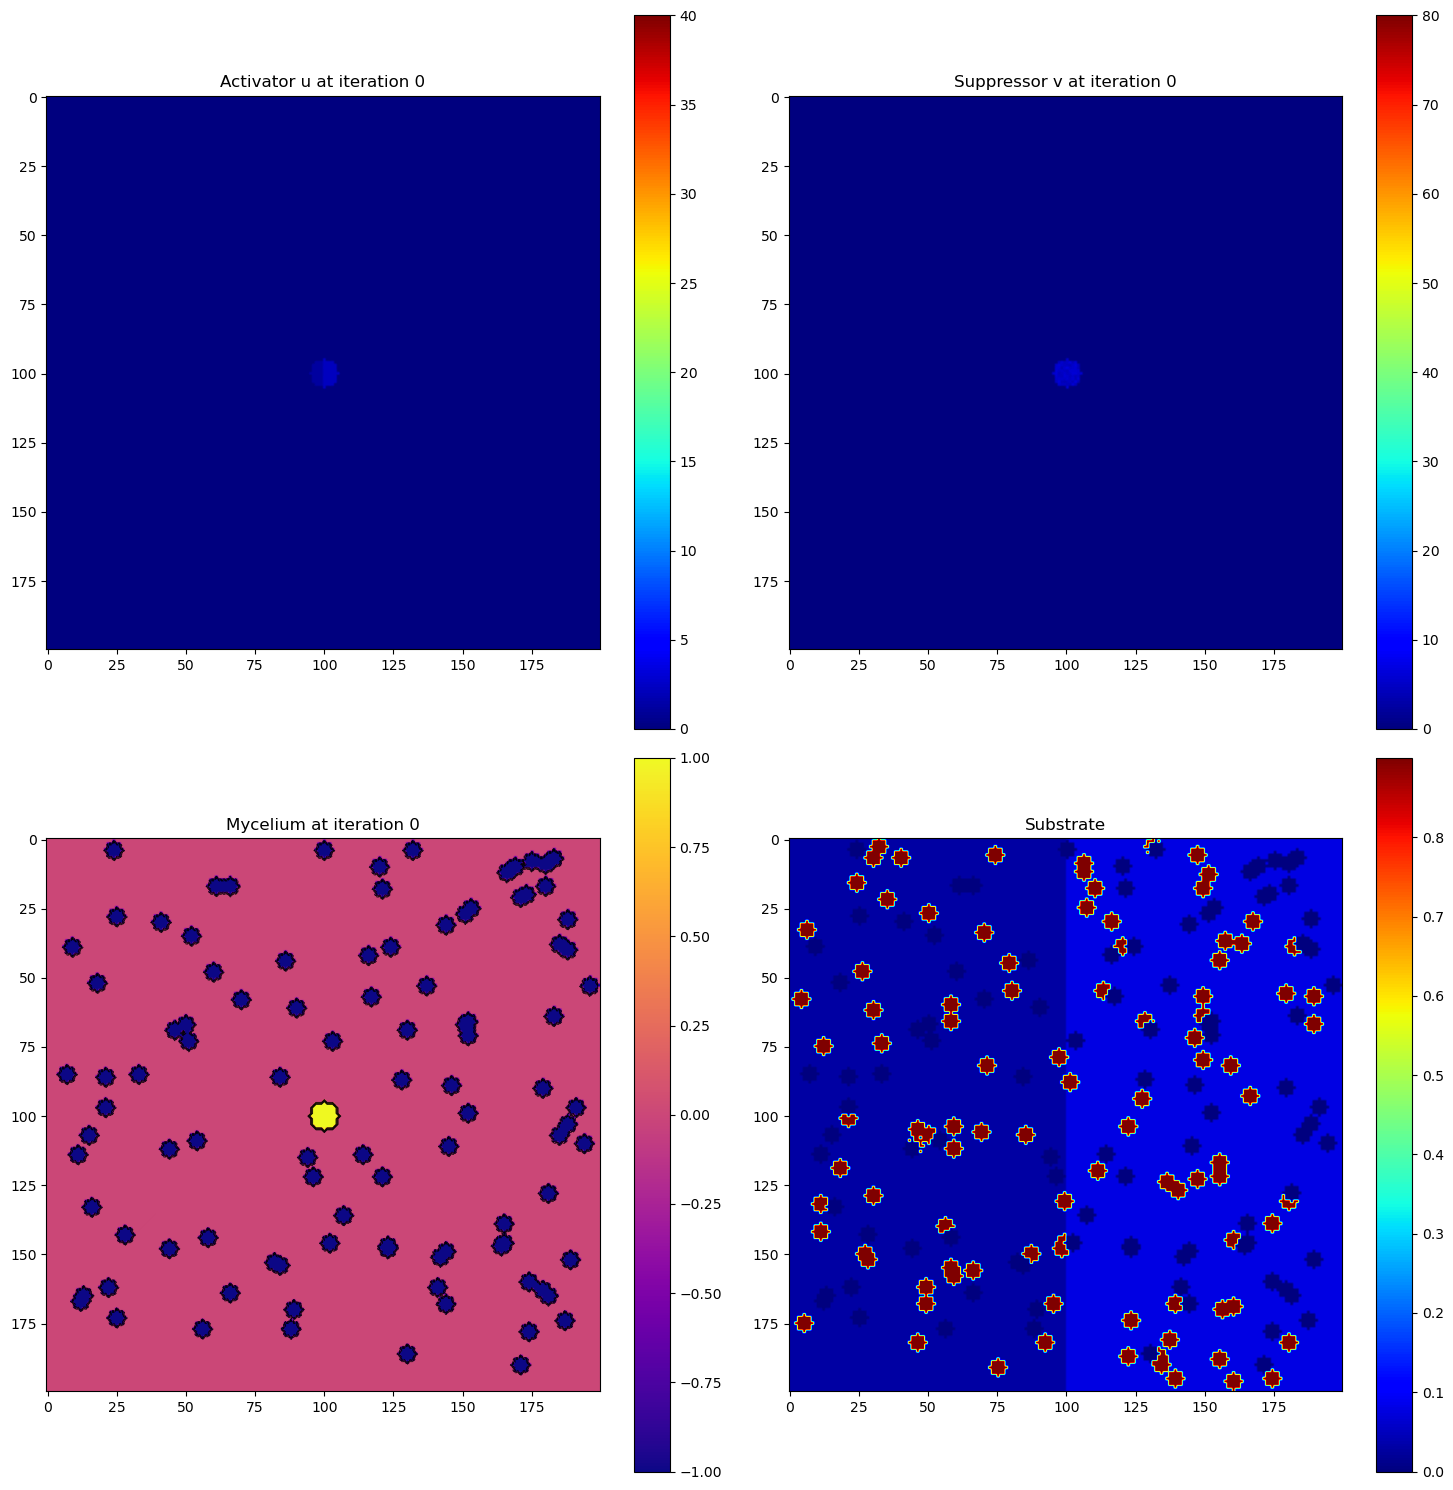

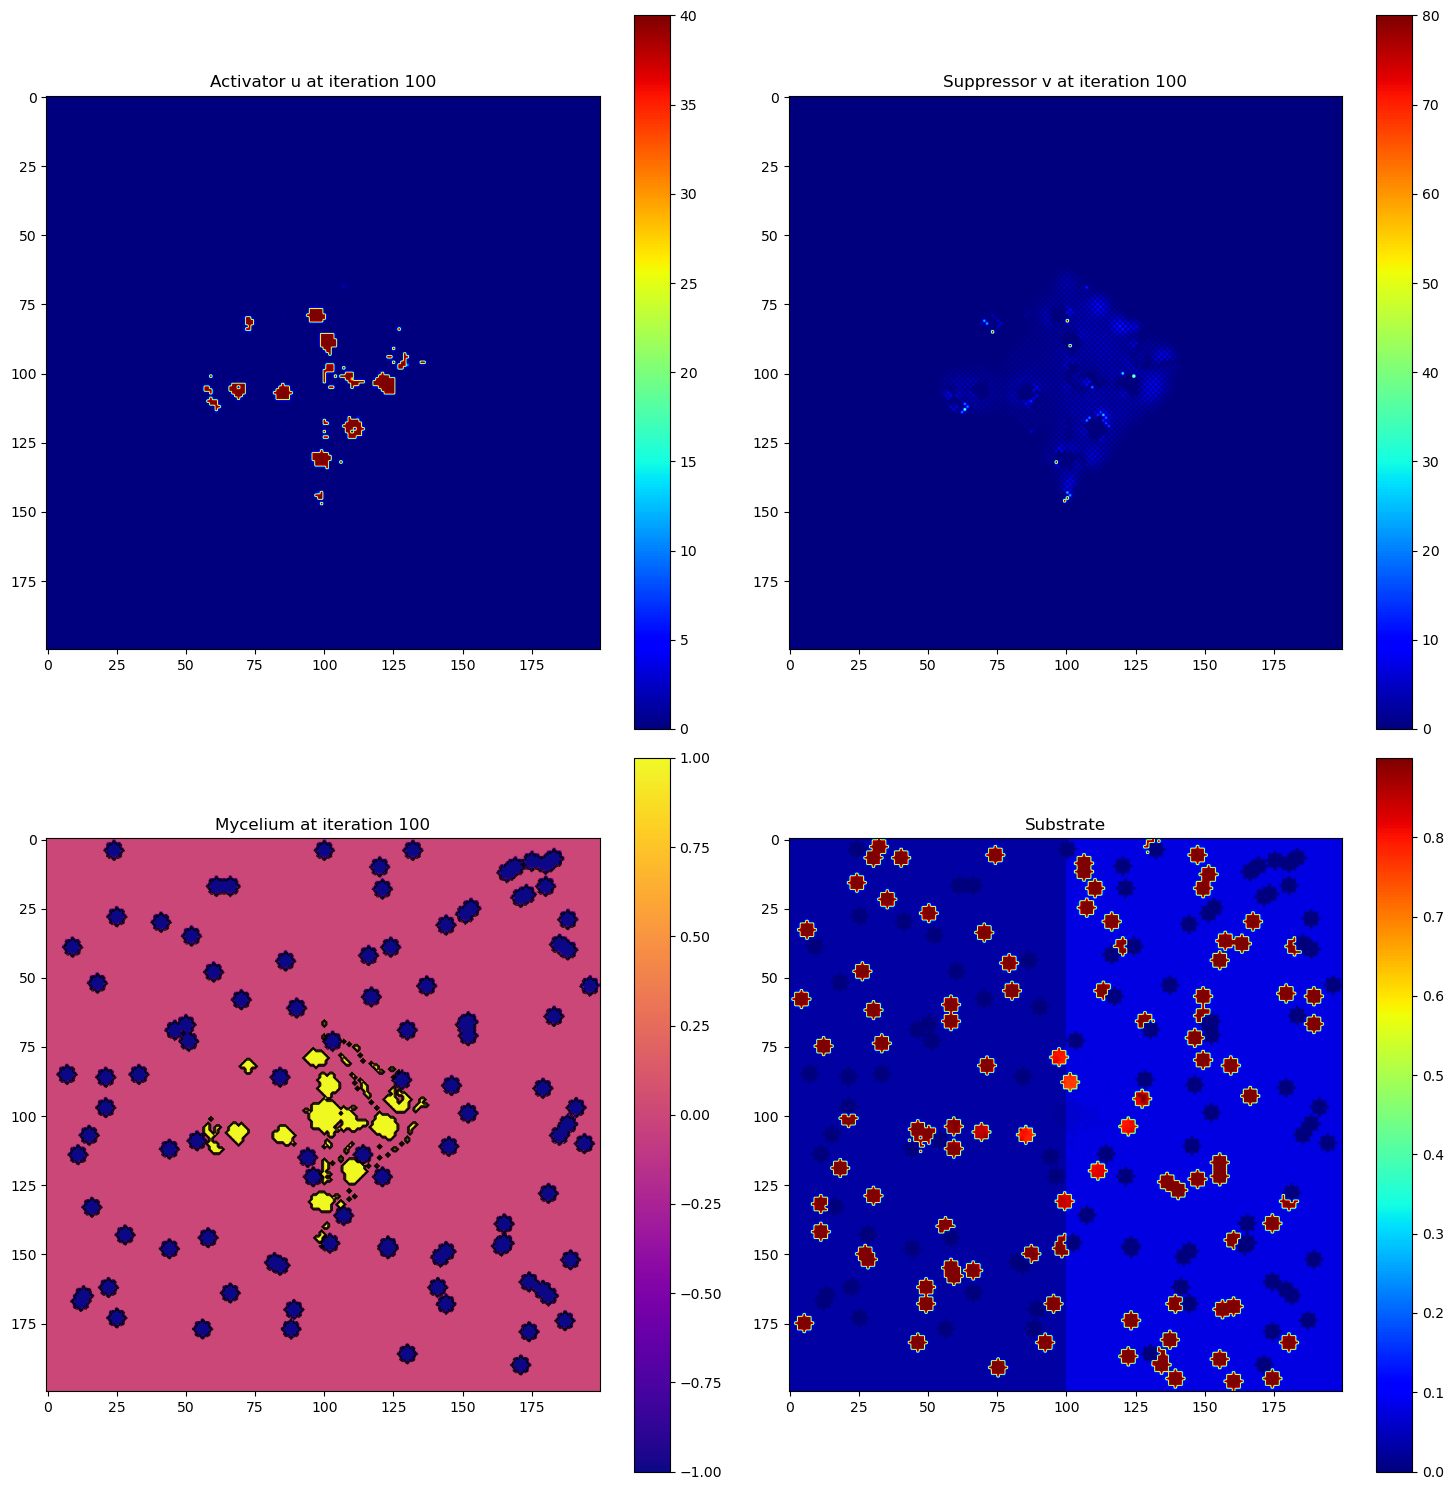

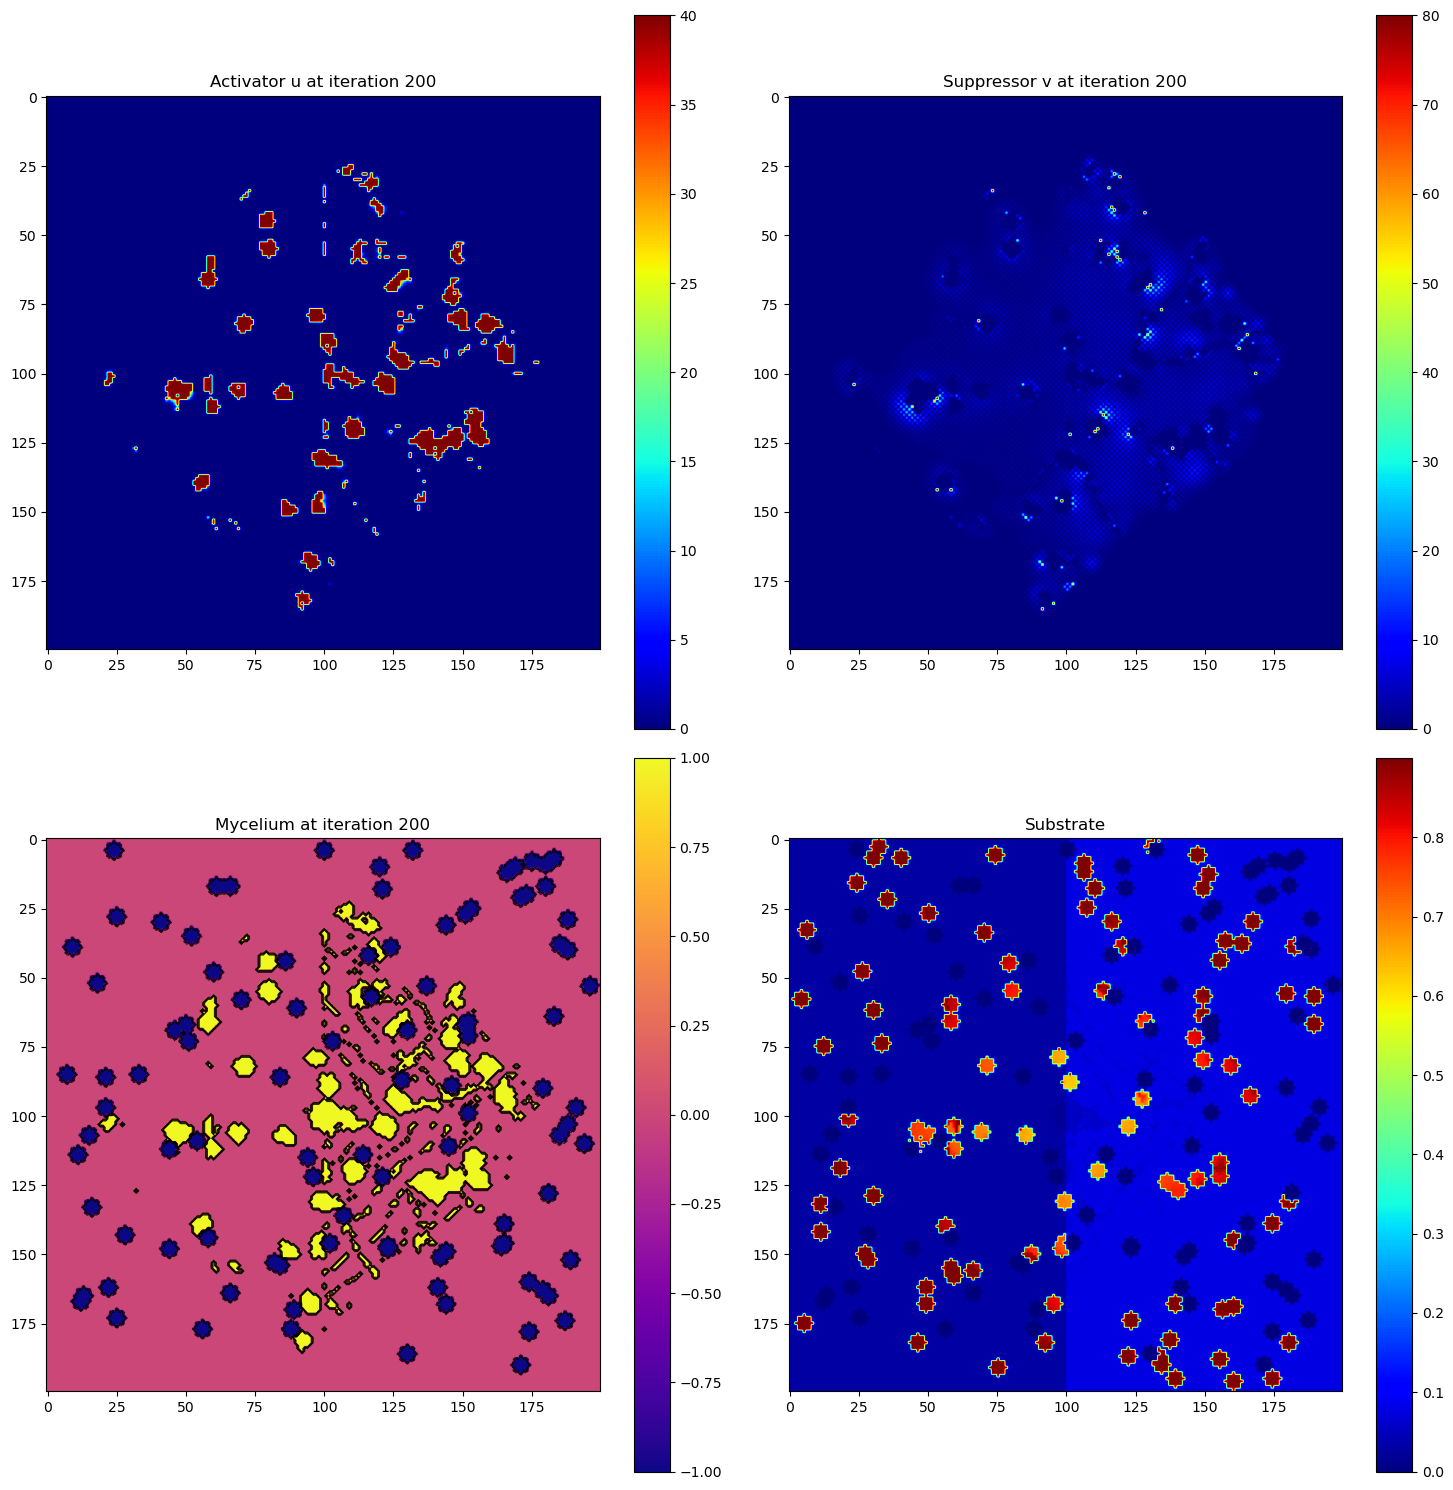

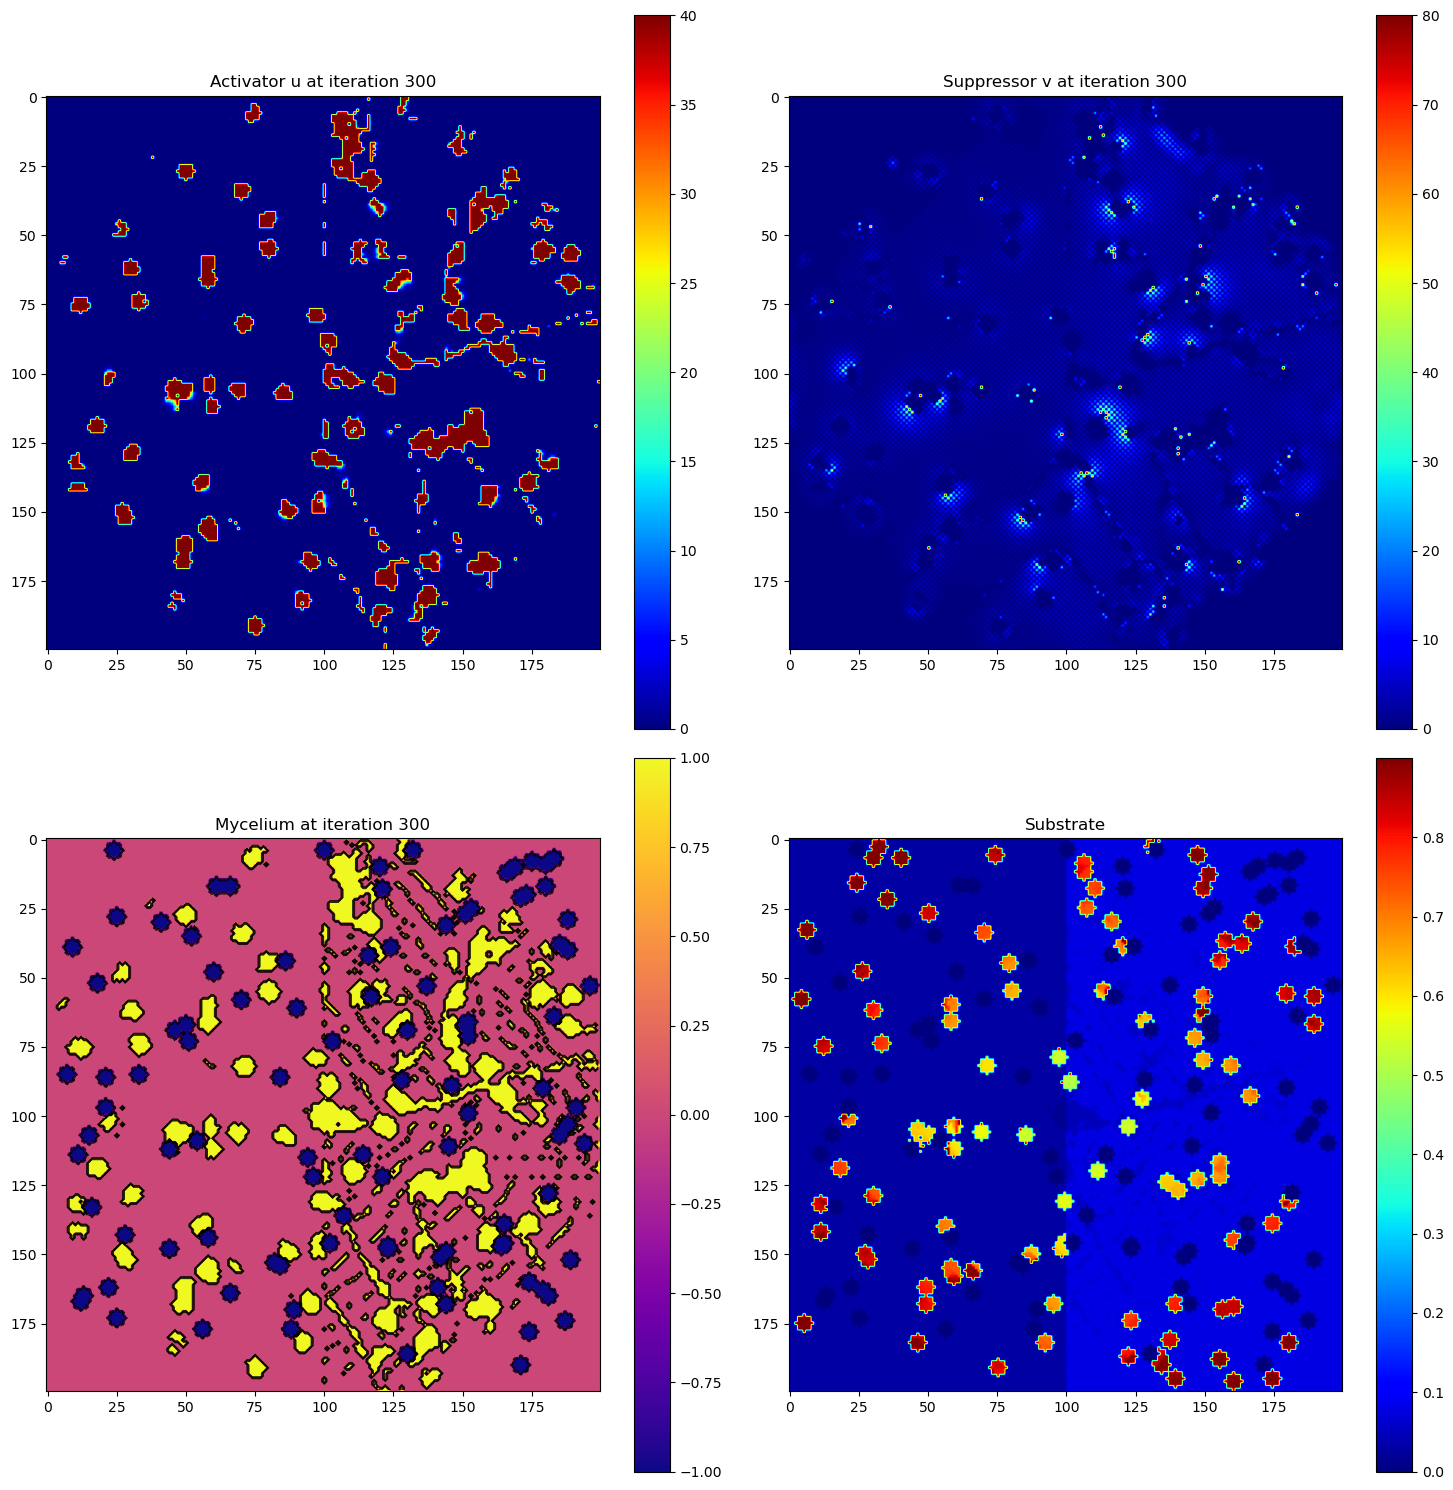

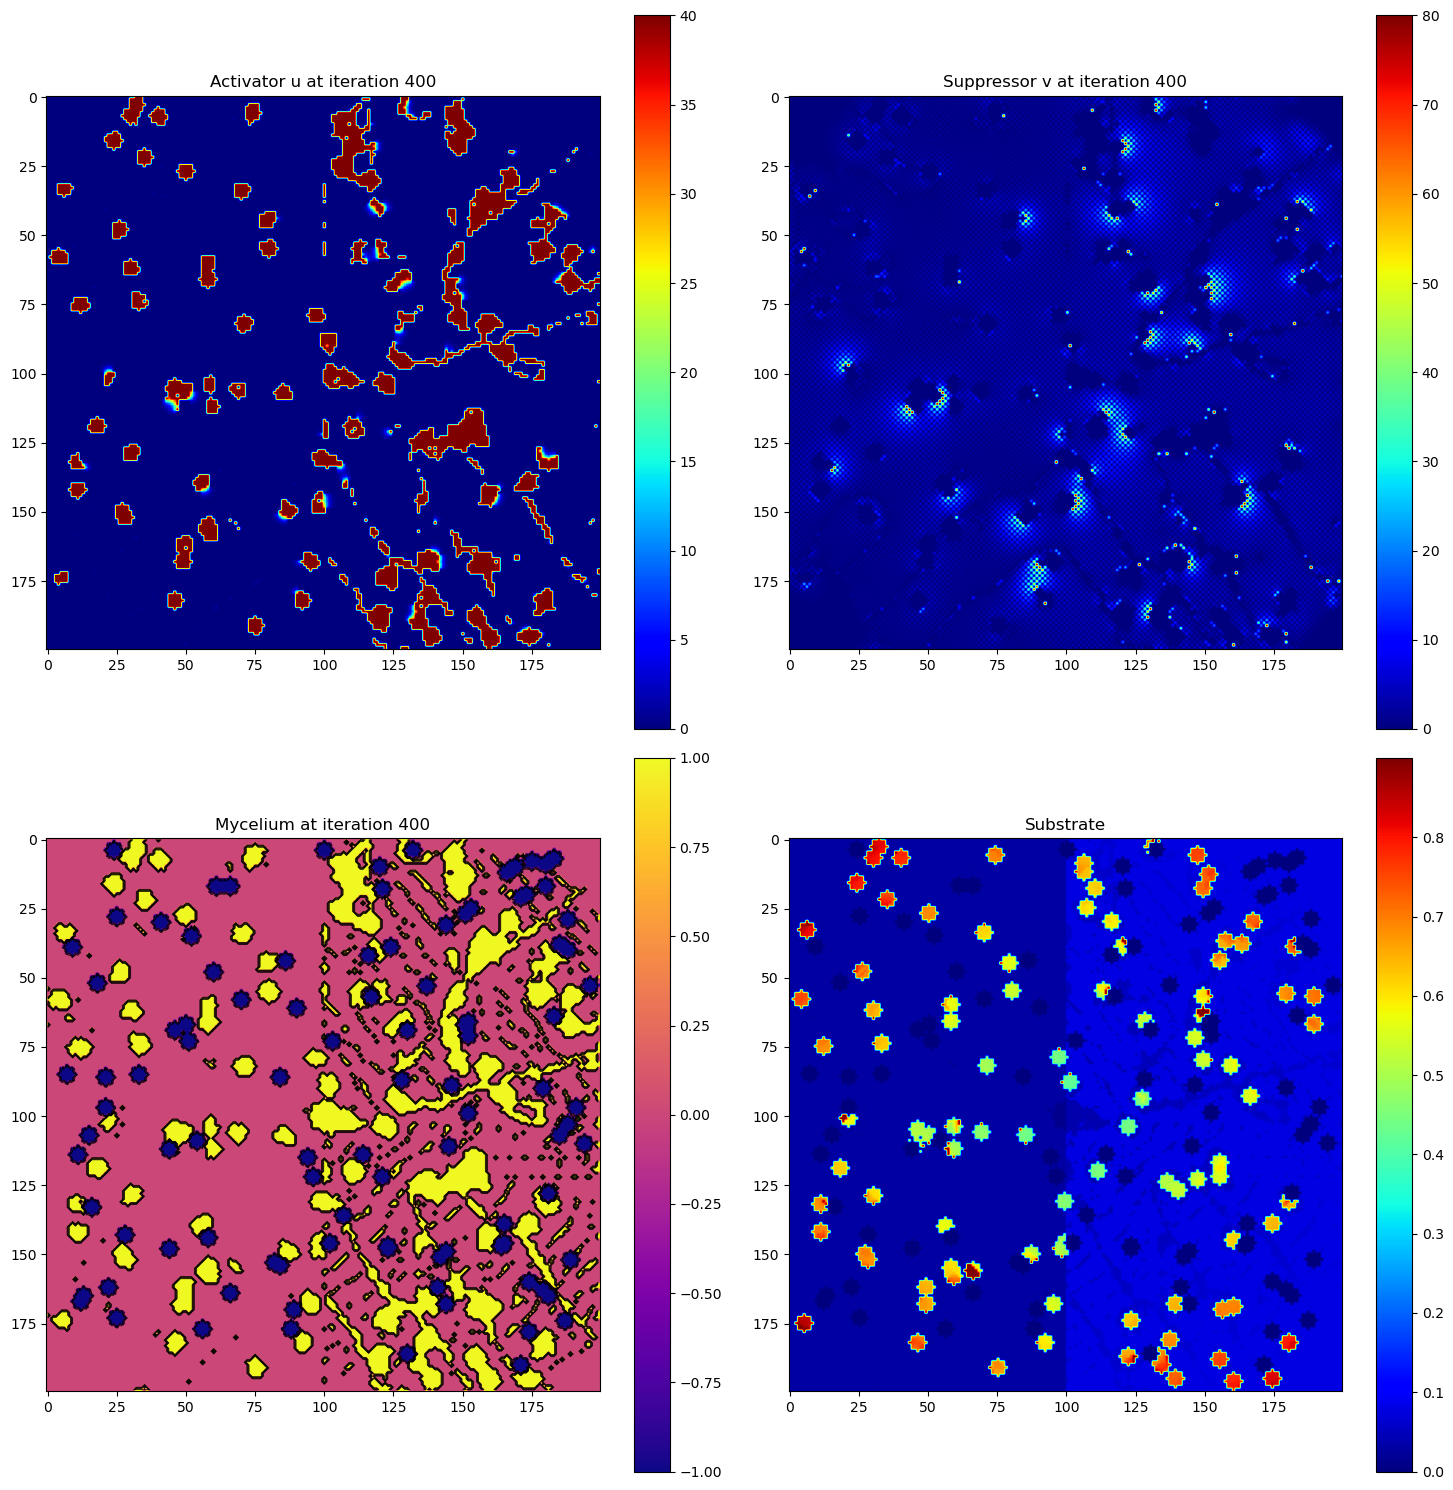

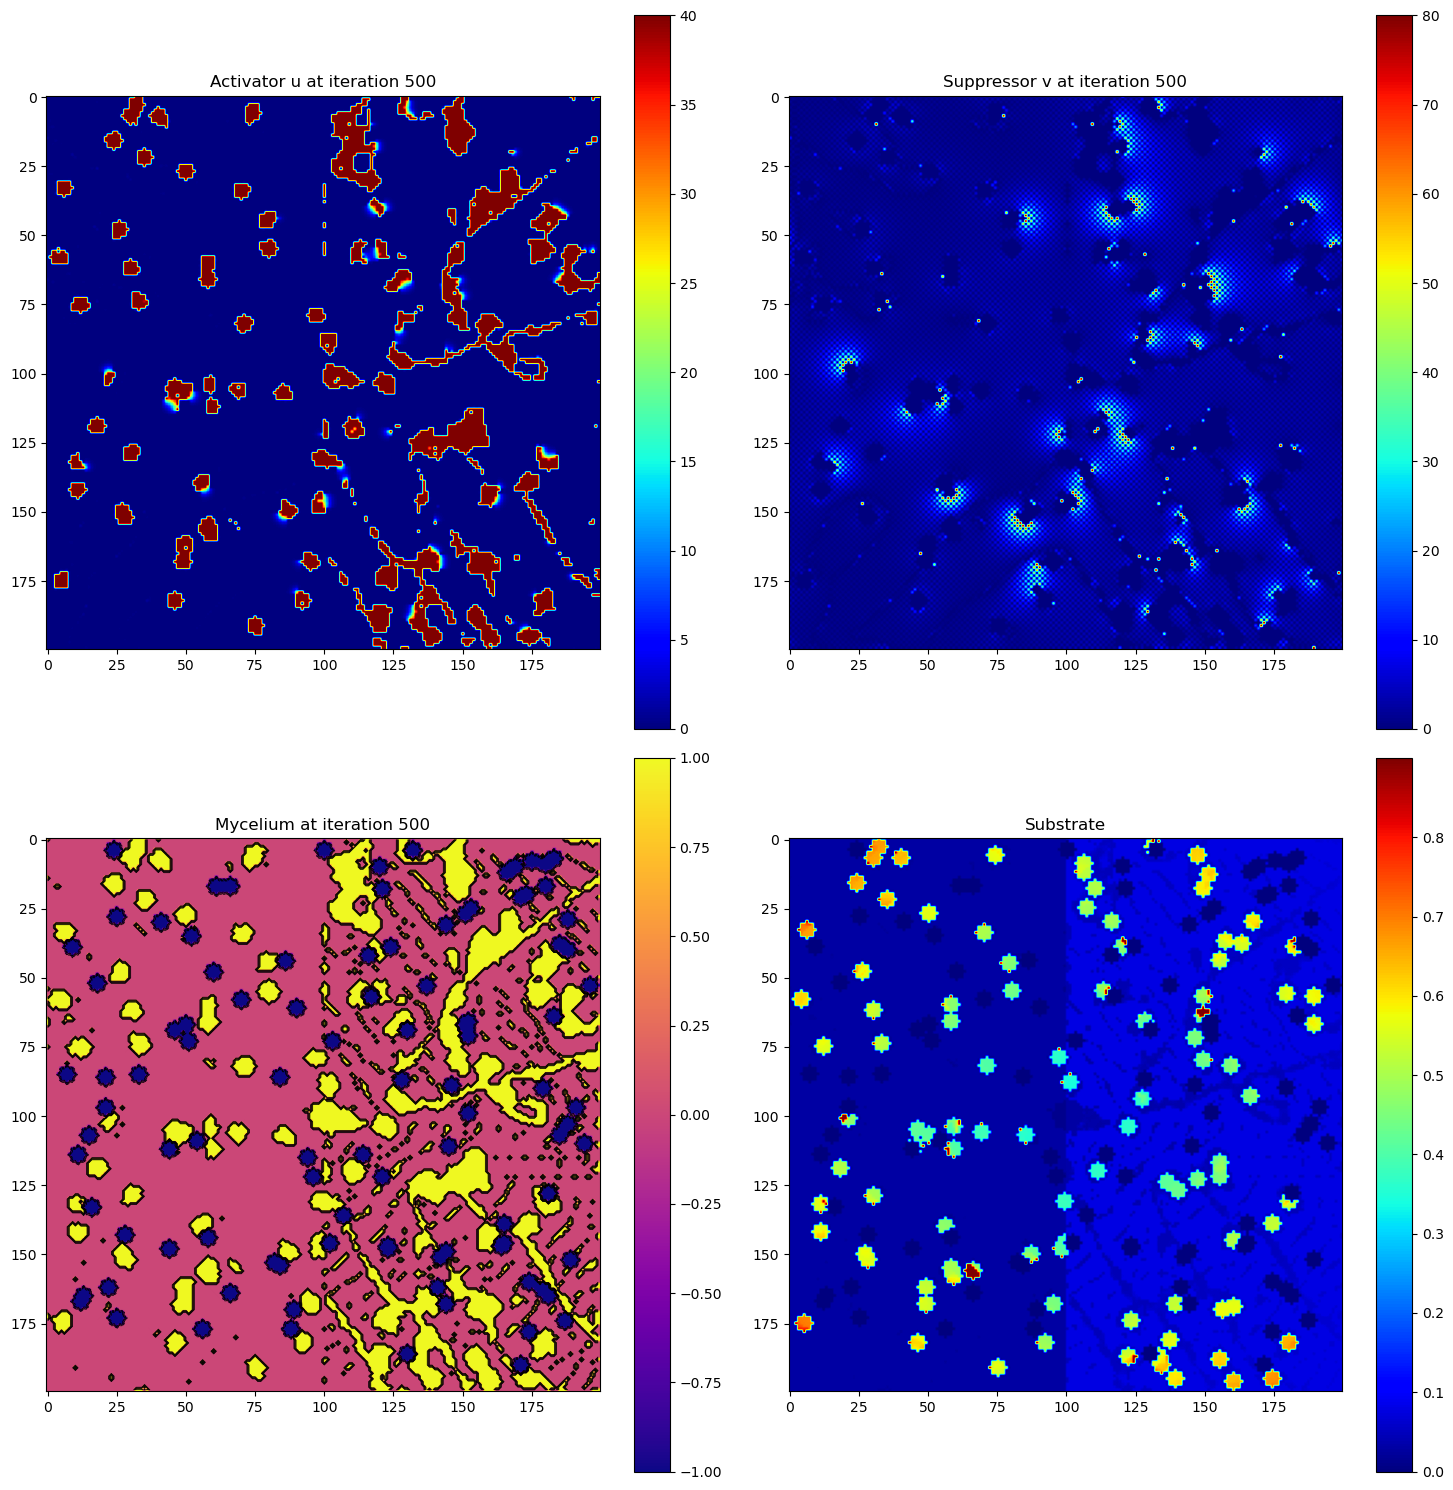

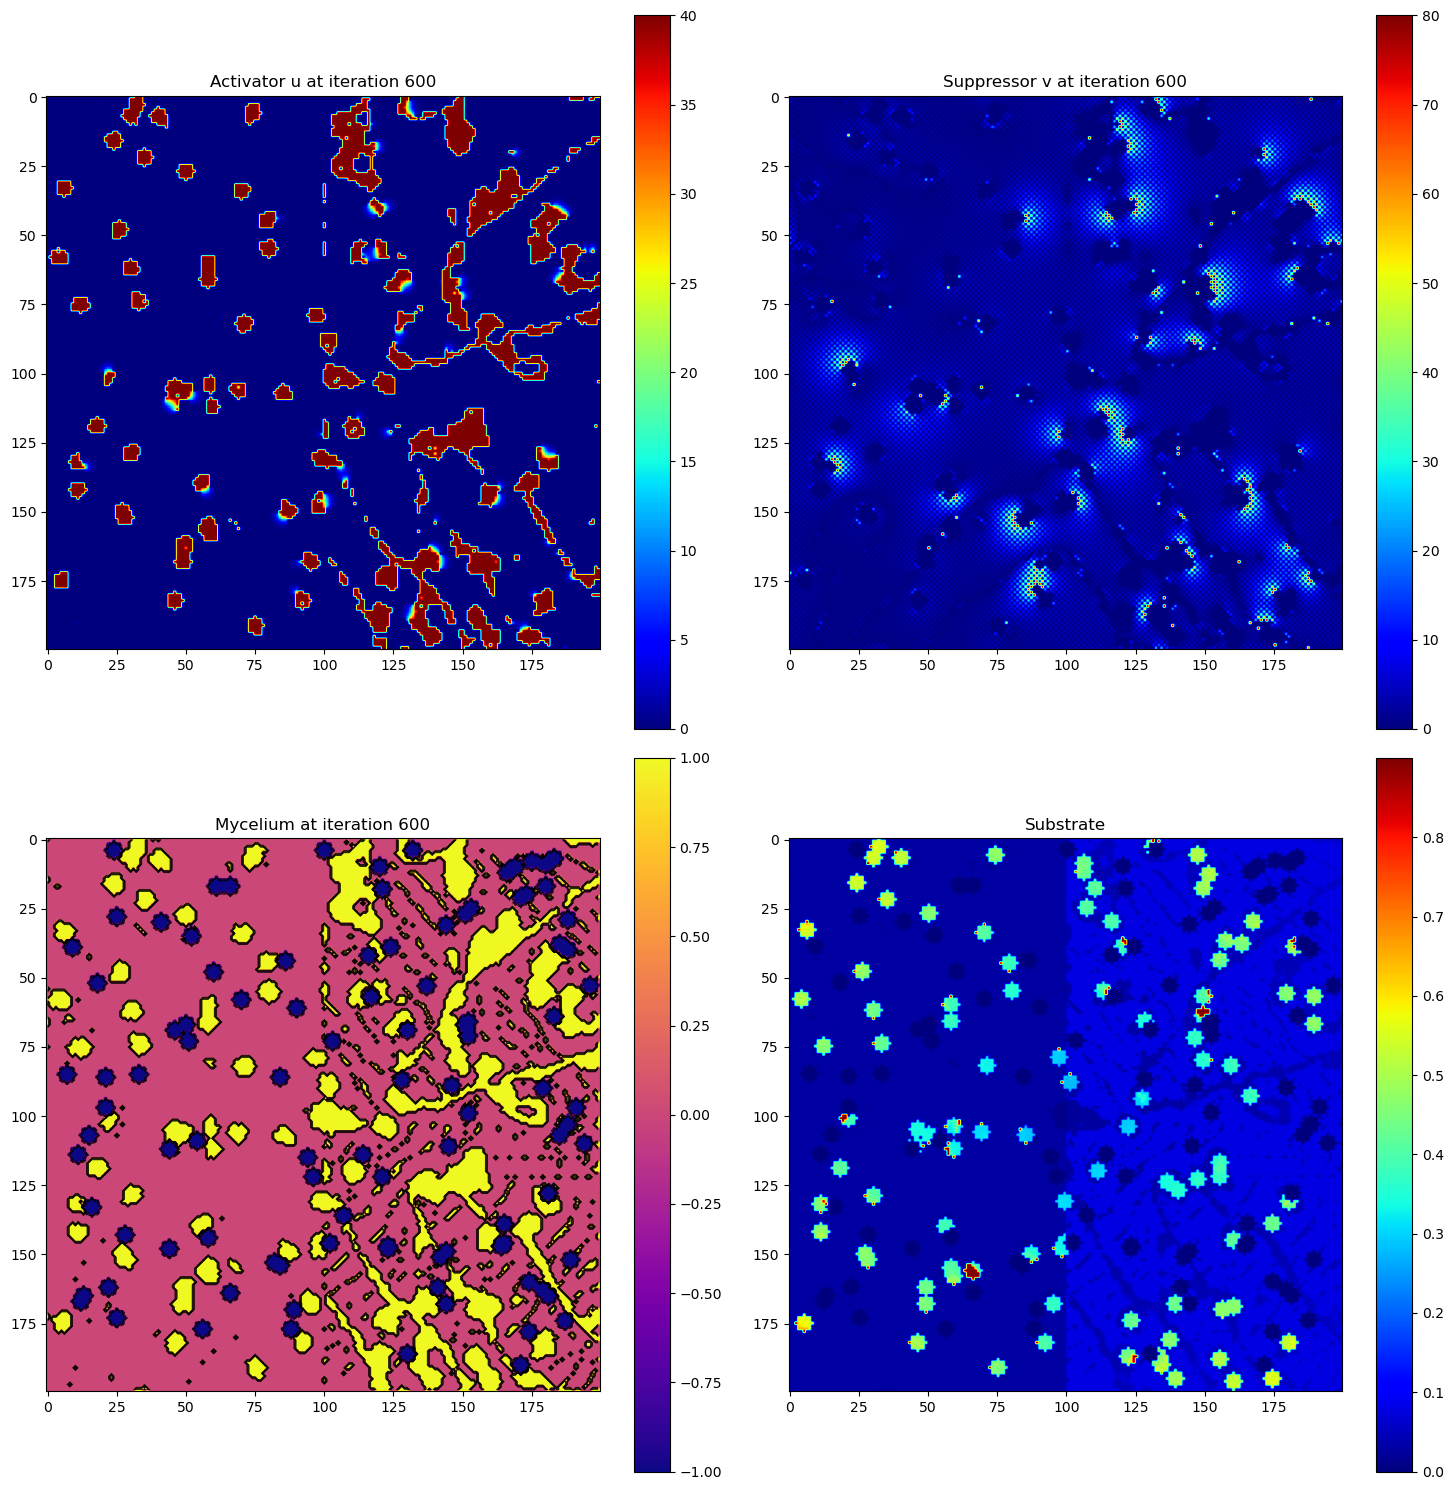

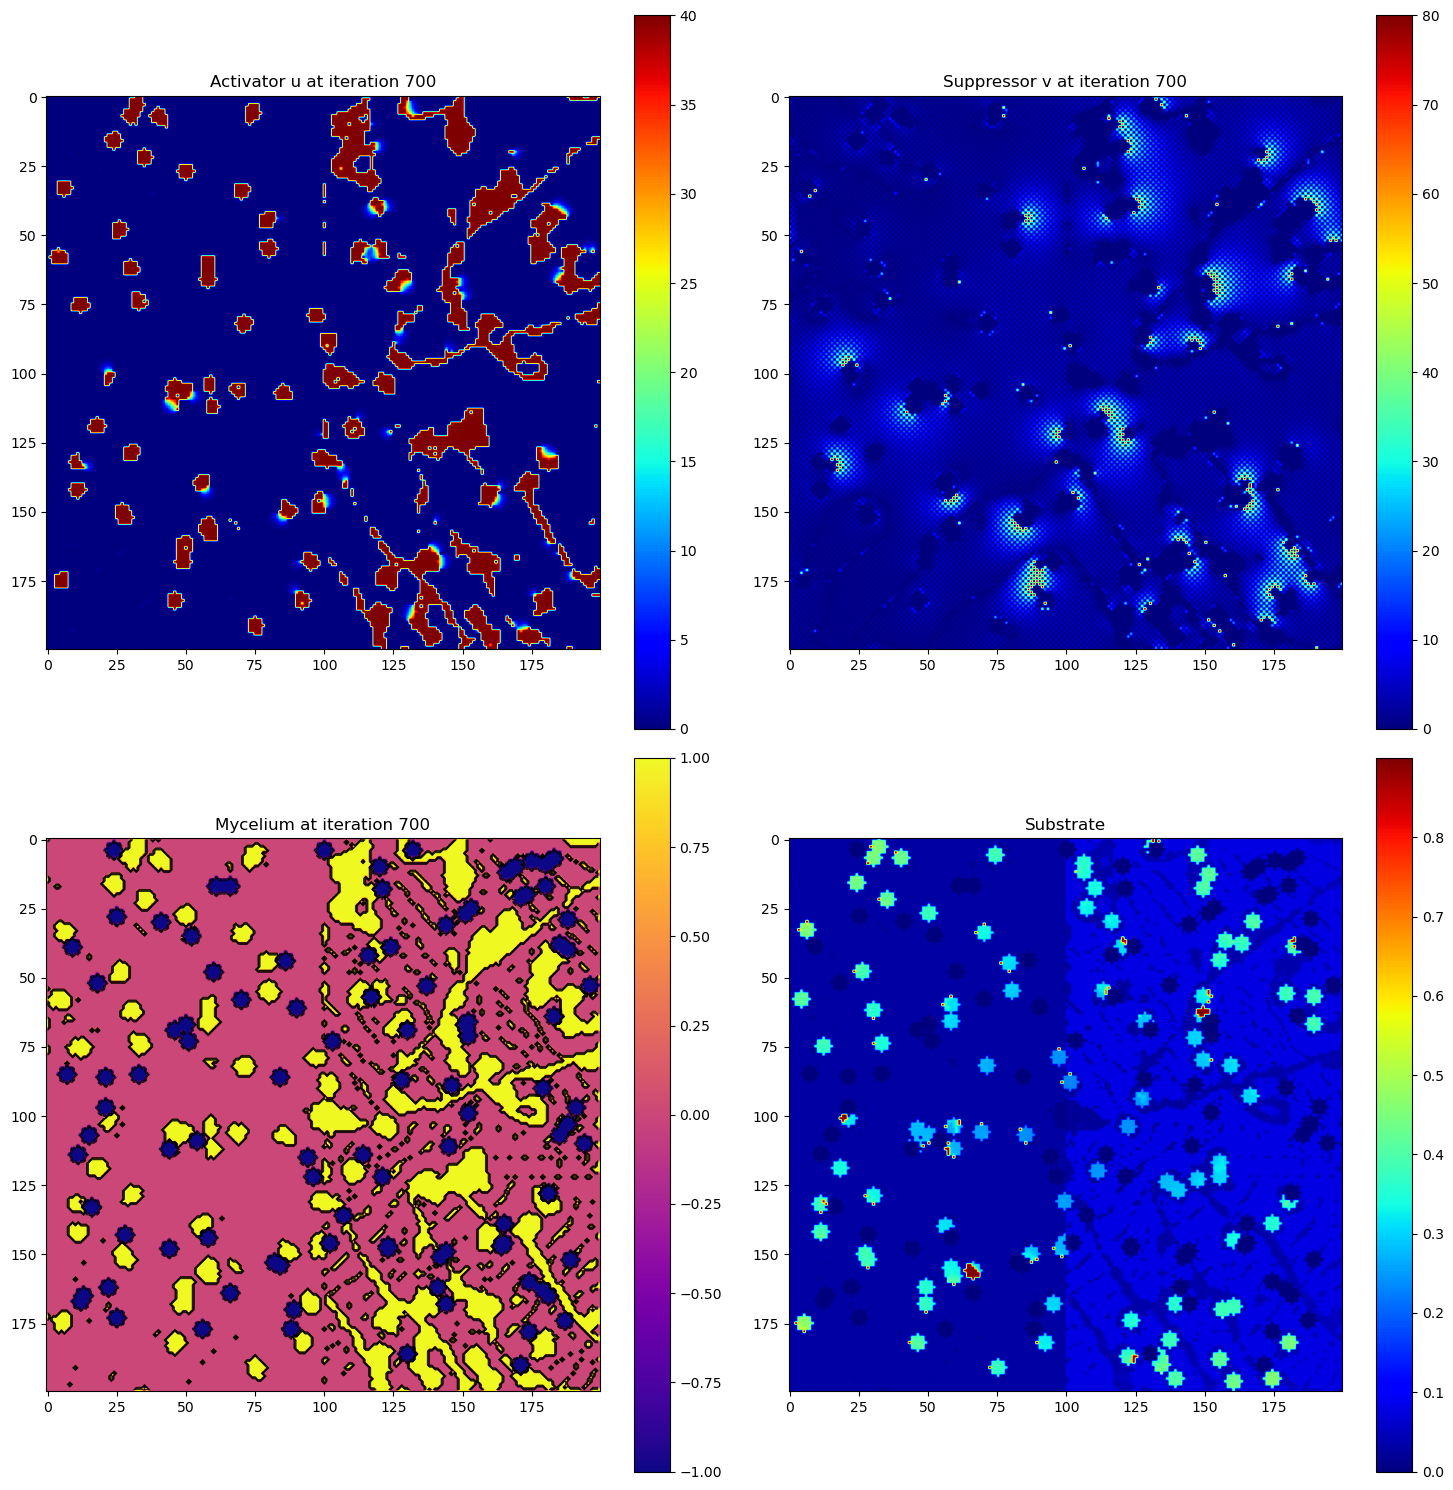

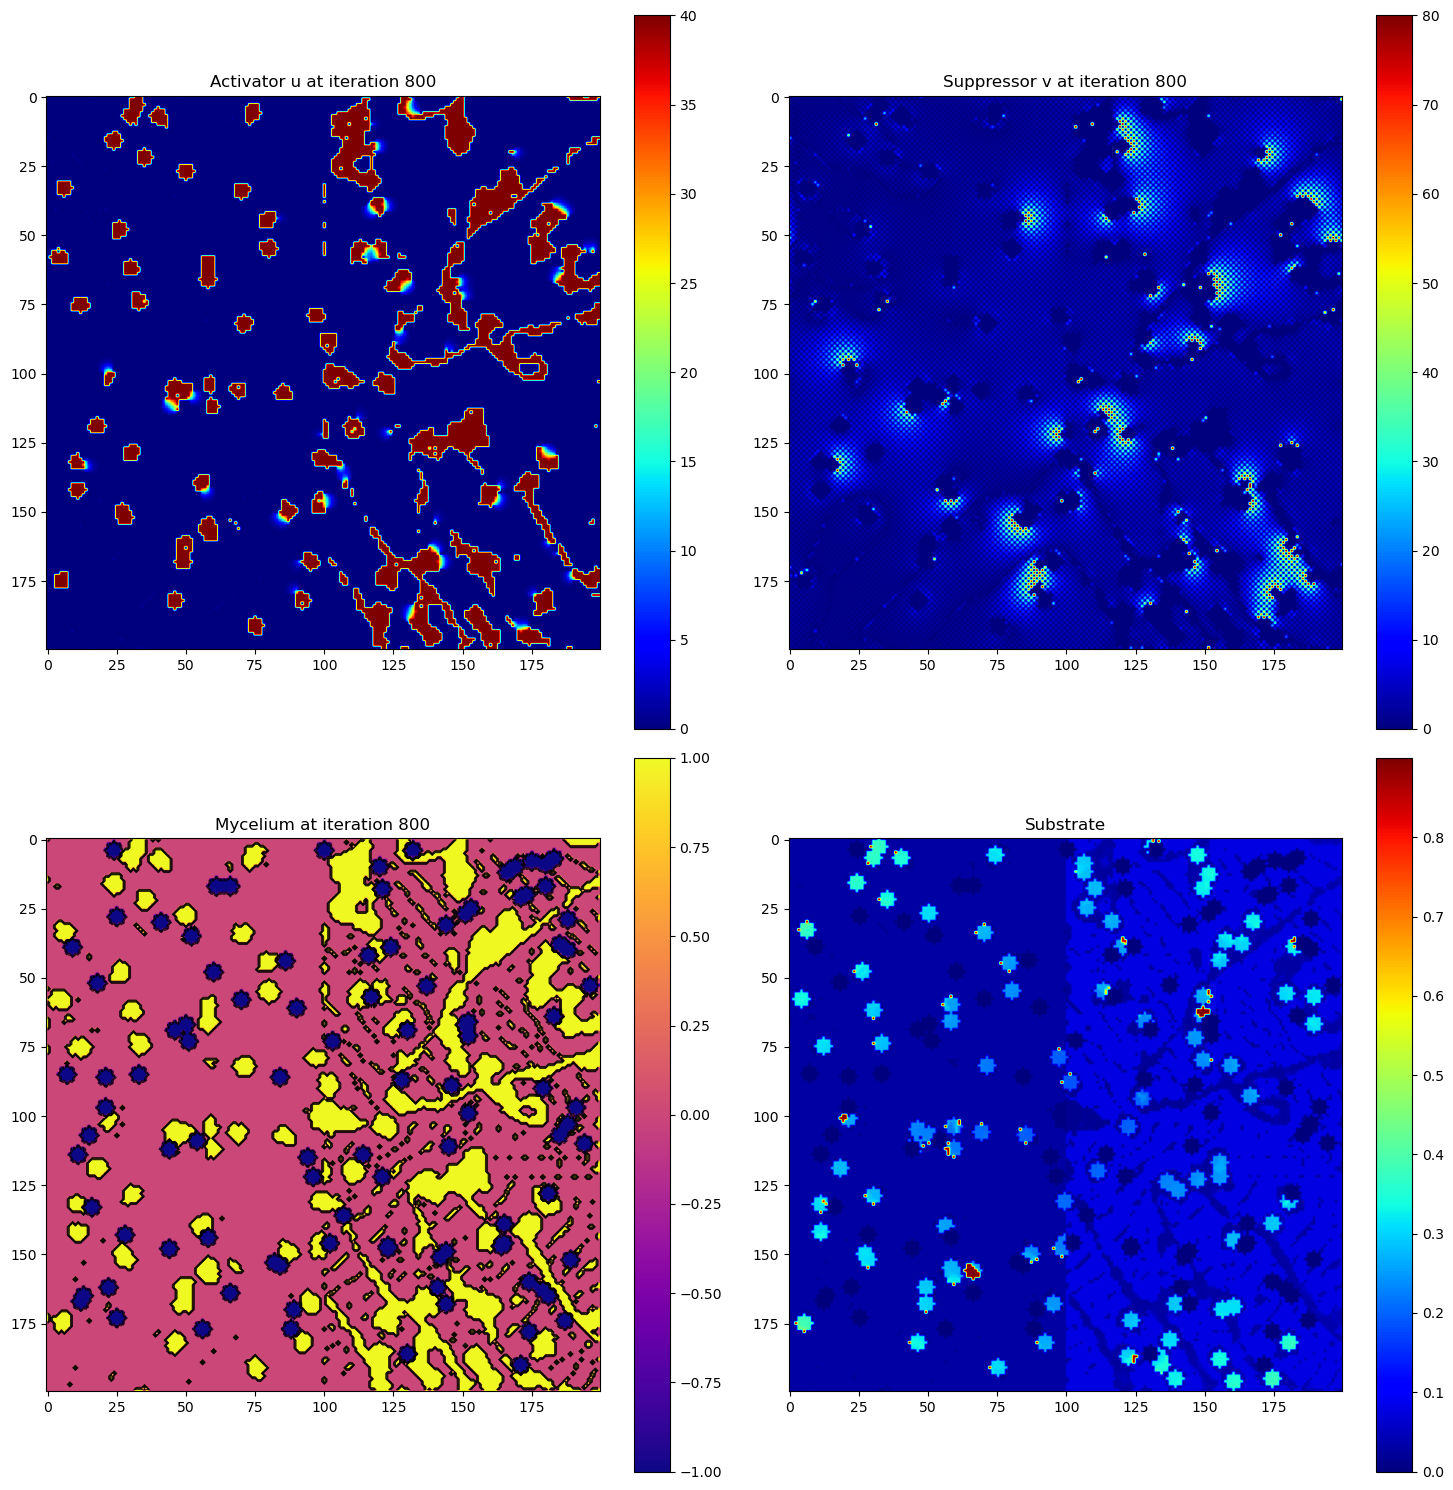

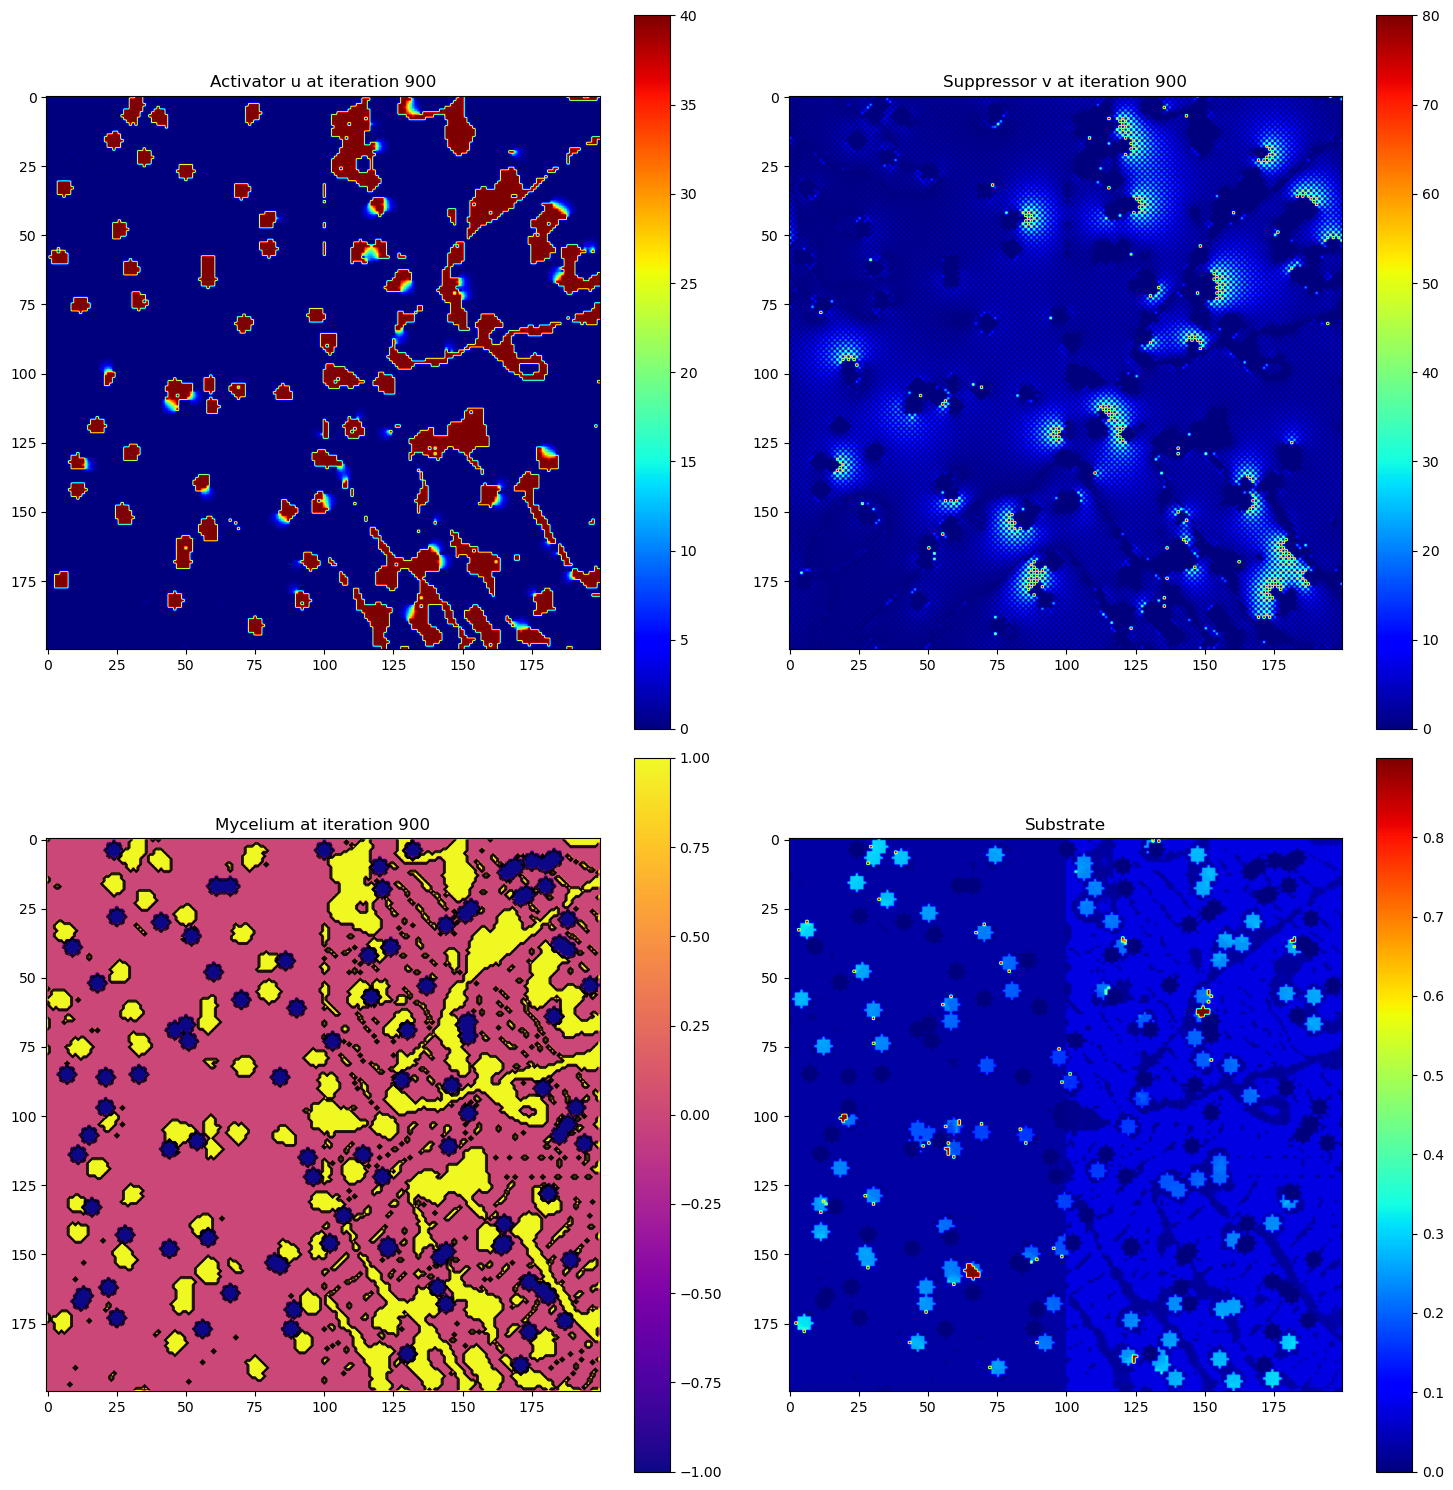

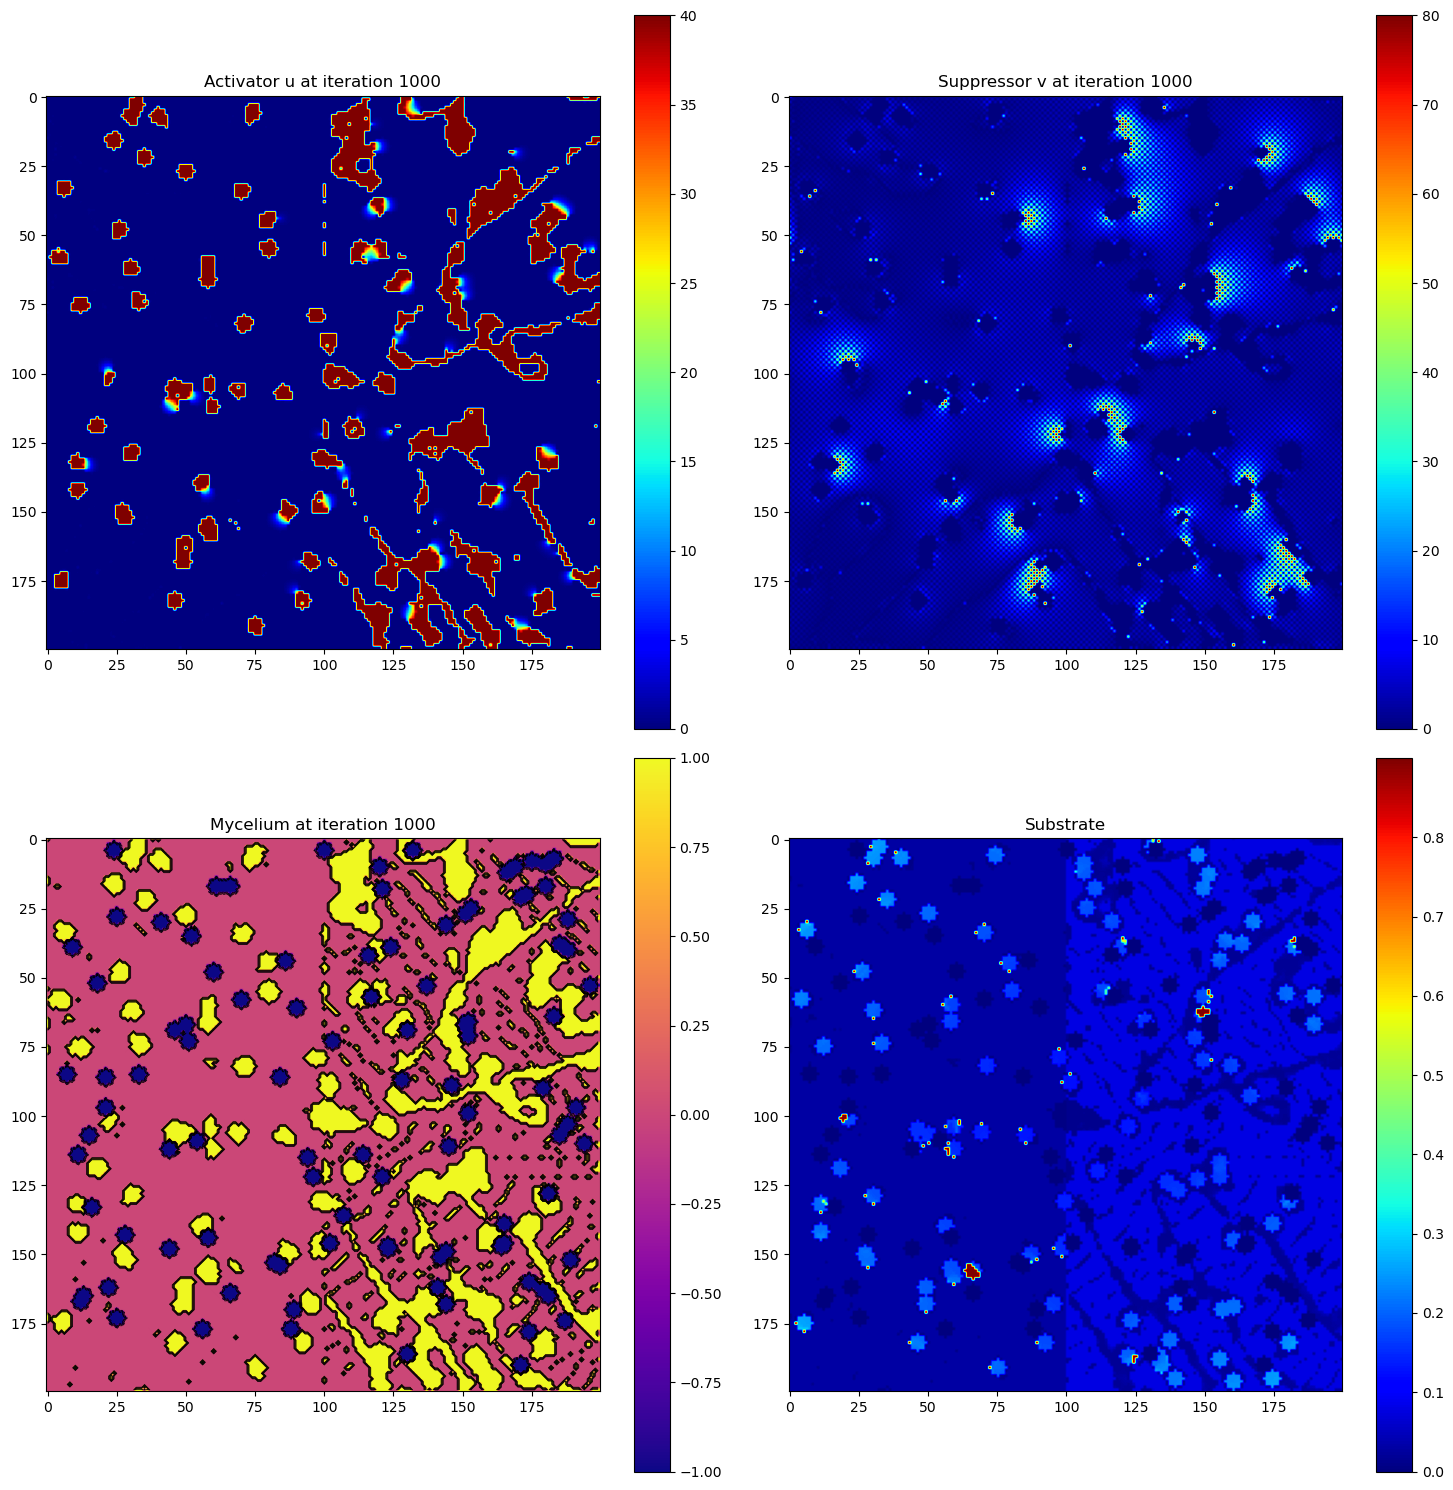

In [47]:
# Main simulation loop
base_consumption_rate = 0.002
for step in range(total_iterations+1):
    # Reaction Terms that control chemical behavior
    f_uv = width * (pa * u + u ** 2 - pb * u * v) * n
    g_uv = pe * u ** 3 - v  # Enhanced suppressor response

    # Incorporate the radius of the plasmatic membrane
    ij_mat = torch.zeros_like(ij_mat)  # Reset each iteration
    ij_mat[c > 0.5] = 1  # Fill ij_mat based on the mycelium matrix

    # Update activator and suppressor
    v_new = v + dt * (d * (0.05 * (torch.roll(v, 1, 0) + torch.roll(v, -1, 0) +
                                    torch.roll(v, 1, 1) + torch.roll(v, -1, 1)) - 0.2 * v) + gamma * g_uv)
    u_new = u + dt * (0.05 * (torch.roll(u, 1, 0) + torch.roll(u, -1, 0) +
                              torch.roll(u, 1, 1) + torch.roll(u, -1, 1)) - 0.2 * u + gamma * f_uv)

    # Apply threshold and adjust alpha
    alpha = torch.where(u <= threshold, 0.49, 0.49 - 2.5 * (u - threshold))
    v_new[u > threshold] = 0

    # Update c using alpha and apply limits
    c_new = c + dt * (gamma * ph * c * (alpha - c) * (c - 1))
    c_new = torch.where(alpha < 0, torch.ones_like(c_new), c_new)
    c_new[n == 0] = -1  # Growth is prevented where nutrients are 0 (rocks)

    # Limiters of activator and suppressor to avoid exponential growth
    u_new = torch.clamp(u_new, 0, amax)
    v_new = torch.clamp(v_new, 0, smax)

    # Proportional Nutrient Consumption: Mycelium consumes nutrients based on available nutrients
    n = n - base_consumption_rate * c_new * n  # Consumption proportional to available nutrients and mycelium
    n = torch.clamp(n, min=0)  # Prevent negative nutrient values

    # Update variables
    u, v, c = u_new, v_new, c_new

    # Visualization every 20 steps
    if step % 100 == 0:
        update_visualization(step, u, v, c, n)